In [1]:
import os
import pandas as pd
import numpy as np
import category_encoders as ce

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import DBSCAN

In [2]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, os.pardir, "Data\\Clean\\Player_Final.csv")

In [3]:
df = pd.read_csv(data_dir)

In [4]:
player_df = df.copy()

In [5]:
df["Pos"]

0       LM
1       AM
2       RW
3       FW
4       CB
        ..
2487    CM
2488    RW
2489    LW
2490    LW
2491    AM
Name: Pos, Length: 2492, dtype: object

In [6]:
# Save the information relate to identification
player_inf_attributes = player_df[['name', 'current_club_name', 'Nation', 'Pos', 'foot']]

# pd.concat([player_encoded_df[['name', 'current_club_name', 'Nation']], df['Pos'], df['foot']])

# Processing data to be able to applying algorithm

## Encode process

In [7]:
# Khởi tạo bộ mã hóa Binary Encoder
binary_encoder = ce.BinaryEncoder(cols=['Pos'])
player_pos_encoded_df = binary_encoder.fit_transform(player_df)

# Khởi tạo và thực hiện One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
encoded_foot = encoder.fit_transform(player_df[['foot']])
encoded_foot_df = pd.DataFrame(encoded_foot, columns=encoder.get_feature_names_out(['foot']))

# Concat the encode process
player_encoded_df = pd.concat([player_pos_encoded_df.drop('foot', axis=1), encoded_foot_df], axis = 1)

c:\Users\Admin\anaconda3\envs\datascience\Lib\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


In [8]:
# attributes in use
X = player_encoded_df[['Pos_0',  'Pos_1',  'Pos_2',  'Pos_3', "Min","Summary_Gls","Summary_Ast","Summary_PK","Summary_Sh","Summary_Tkl","Summary_Int","Summary_Blocks","Summary_xAG","Summary_GCA","Summary_Cmp","Summary_Cmp%","Summary_PrgC","Summary_Succ","Passing_short_Cmp%","Passing_medium_Cmp%","Passing_long_Att","Passing_long_Cmp%","Passing_PPA","Passing_CrsPA","Pass_Types_Dead","Pass_Types_TB","Pass_Types_Sw","Pass_Types_Crs","Pass_Types_CK","Pass_Types_Str","Pass_Types_Off","Pass_Types_Blocks","Defensive_Actions_Att 3rd","Defensive_Actions_Tkl%","Defensive_Actions_Lost","Defensive_Actions_Sh","Defensive_Actions_Clr","Defensive_Actions_Err","Possession_Succ%","Possession_Tkld","Possession_CPA","Possession_Mis","Possession_Dis","Possession_PrgR","Miscellaneous_Stats_Fld","Miscellaneous_Stats_Won%"]]

# Chuẩn hóa dữ liệu (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chuyển dữ liệu về numpy array
X_scaled = np.array(X_scaled)

In [9]:
attributes = ['Pos_0',  'Pos_1',  'Pos_2',  'Pos_3', "Min","Summary_Gls","Summary_Ast","Summary_PK","Summary_Sh","Summary_Tkl","Summary_Int","Summary_Blocks","Summary_xAG","Summary_GCA","Summary_Cmp","Summary_Cmp%","Summary_PrgC","Summary_Succ","Passing_short_Cmp%","Passing_medium_Cmp%","Passing_long_Att","Passing_long_Cmp%","Passing_PPA","Passing_CrsPA","Pass_Types_Dead","Pass_Types_TB","Pass_Types_Sw","Pass_Types_Crs","Pass_Types_CK","Pass_Types_Str","Pass_Types_Off","Pass_Types_Blocks","Defensive_Actions_Att 3rd","Defensive_Actions_Tkl%","Defensive_Actions_Lost","Defensive_Actions_Sh","Defensive_Actions_Clr","Defensive_Actions_Err","Possession_Succ%","Possession_Tkld","Possession_CPA","Possession_Mis","Possession_Dis","Possession_PrgR","Miscellaneous_Stats_Fld","Miscellaneous_Stats_Won%"]

In [10]:
player_inf_attributes['Pos']

0       LM
1       AM
2       RW
3       FW
4       CB
        ..
2487    CM
2488    RW
2489    LW
2490    LW
2491    AM
Name: Pos, Length: 2492, dtype: object

In [11]:
X_scaled[:5]

array([[-0.75122833, -1.09166507, -0.69331756,  1.15186691, -0.37576378,
        -0.62686271,  0.19480582, -0.20978042, -0.66997481,  0.28708384,
        -0.20038636, -0.39989302,  0.29155801, -0.28655402,  0.48715303,
         0.59214301, -0.19133404, -0.42289677,  0.3687937 ,  0.76968124,
        -0.00887648,  0.45221791,  1.0705302 ,  1.23772342,  0.70892593,
         0.59304578, -0.10931781,  0.61256132,  0.12007191, -0.13251605,
         0.53082705,  0.50229523, -0.16813548,  0.87458208, -0.11871671,
        -0.66012474, -0.27816638, -0.34390448, -0.14169705, -0.48699885,
        -0.118947  , -0.44499805, -0.1616371 ,  0.96432336, -0.49287943,
        -0.22529208],
       [-0.75122833, -1.09166507,  1.4423405 , -0.86815585,  0.81832022,
         1.02916958,  2.1162973 , -0.20978042,  1.60279888, -0.48997059,
        -0.40812974,  0.02492626,  3.67064542,  2.96674248,  1.03164278,
         0.20580051,  1.11601483,  0.13882884,  0.31162255,  0.46060102,
         1.25535966,  0.65838

# **Algorithm & Model**

## **Similarity-based Models** (Base on Euclidean distance)

In [48]:
# position_attributes = ['Pos_0', 'Pos_1', 'Pos_2', 'Pos_3']
# # Tạo mảng trọng số với các giá trị mặc định là 1
# weights = np.ones(len(attributes))

# # Gán trọng số 5 cho các thuộc tính vị trí
# for pos_attr in position_attributes:
#     if pos_attr in attributes:
#         pos_index = attributes.index(pos_attr)
#         weights[pos_index] = 5

# Tính ma trận độ tương đồng Cosine giữa các cầu thủ
euclid_sim = euclidean_distances(X_scaled)
euclid_sim 

# To find top_k nearest player
def find_similar_players(player_index, top_k):
    sim_scores = list(enumerate(euclid_sim[player_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # Sắp xếp giảm dần
    sim_scores = sim_scores[1:top_k+1]  # Bỏ chính cầu thủ đó
    similar_players = [(player_inf_attributes.iloc[i]["name"], score, i) for i, score in sim_scores]
    return similar_players

# Display k player best match
def list_player(player_index, top_k=5):
    print(f"Cầu thủ gốc: {player_inf_attributes.iloc[player_index]["name"]}\nVị trí: {player_inf_attributes.iloc[player_index]["Pos"]}\nchân: {player_inf_attributes.iloc[player_index]["foot"]}")
    print("Top cầu thủ tương tự:")
    for player, score, i in find_similar_players(player_index, top_k):
        print(f"player: {player}\t\tposition: {player_inf_attributes.iloc[i]["Pos"]}\t\tscore: {score:.4f}")

list_player(12, 10)


Cầu thủ gốc: Thomas Mangani
Vị trí: CM
chân: left
Top cầu thủ tương tự:
player: Bukayo Saka		position: RW		score: 26.2940
player: Warren Zaïre-Emery		position: RM		score: 25.8812
player: Lionel Messi		position: FW		score: 24.0530
player: Soumaïla Coulibaly		position: CB		score: 23.1252
player: Kevin De Bruyne		position: CM		score: 22.7465
player: Téji Savanier		position: AM		score: 22.0054
player: Andrea Ranocchia		position: CB		score: 21.5458
player: Kieran Trippier		position: RB		score: 20.5478
player: Christian Kühlwetter		position: RM		score: 19.6242
player: Cole Palmer		position: RW		score: 19.4872


## **Similarity-based Models** (Base on Cosine Similarity)

In [32]:
# Tính ma trận độ tương đồng Cosine giữa các cầu thủ
cosine_sim = cosine_similarity(X_scaled)

# To find top_k nearest player
def find_similar_players(player_index, top_k):
    sim_scores = list(enumerate(cosine_sim[player_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # Sắp xếp giảm dần
    sim_scores = sim_scores[1:top_k+1]  # Bỏ chính cầu thủ đó
    similar_players = [(player_inf_attributes.iloc[i]["name"], score, i) for i, score in sim_scores]
    return similar_players

# Display k player best match
def list_player_cs(player_index, top_k=5):
    print(f"Cầu thủ gốc: {player_inf_attributes.iloc[player_index]["name"]}\nVị trí: {player_inf_attributes.iloc[player_index]["Pos"]}\nchân: {player_inf_attributes.iloc[player_index]["foot"]}")
    print("Top cầu thủ tương tự:")
    for player, score, i in find_similar_players(player_index, top_k):
        print(f"player: {player}\t\tposition: {player_inf_attributes.iloc[i]["Pos"]}\t\tscore: {score:.4f}")

list_player_cs(12, 10)

Cầu thủ gốc: Thomas Mangani
Vị trí: CM
chân: left
Top cầu thủ tương tự:
player: Michele Castagnetti		position: CM		score: 0.7326
player: Jon Moncayola		position: CM		score: 0.7242
player: Oliver Norwood		position: CM		score: 0.7039
player: Florian Tardieu		position: CM		score: 0.6856
player: Salvatore Esposito		position: CM		score: 0.6854
player: Unai López		position: CM		score: 0.6607
player: Gerard Gumbau		position: CM		score: 0.6599
player: Simone Bastoni		position: CM		score: 0.6558
player: Pedro Chirivella		position: CM		score: 0.6454
player: Leandro Paredes		position: CM		score: 0.6398


## **Clustering-based Models** (DBSCAN)

In [49]:
# Xây dựng mô hình DBSCAN
dbscan = DBSCAN(eps=4, min_samples=3)  # eps và min_samples cần thử nghiệm
dbscan.fit(X_scaled)

# Thêm kết quả phân cụm vào DataFrame
new_df = player_encoded_df.copy()
new_df['Cluster'] = dbscan.labels_

# cluster_result
# print(new_df[['name', 'Cluster']].sort_values(by='Cluster'))

# Hàm tìm cầu thủ trong cùng cụm
def find_players_in_same_cluster(player_index):
    cluster_id = new_df.loc[player_index, 'Cluster']
    if cluster_id == -1:
        print("Cầu thủ này là outlier (nằm ngoài các cụm).")
        return []
    # Lấy danh sách cầu thủ trong cùng cụm
    same_cluster = new_df[new_df['Cluster'] == cluster_id]
    # Loại bỏ chính cầu thủ đang tìm
    # current_player_name = new_df.loc[player_index, 'name']
    # if current_player_name in same_cluster:
    #     same_cluster.remove(current_player_name)
    same_cluster = same_cluster[same_cluster.index != player_index]
    list_idx =  same_cluster[['name']].reset_index()['index'][:10].tolist()
    for i in list_idx:
        print(f"player: {player_inf_attributes.iloc[i]["name"]}\t\tposition: {player_inf_attributes.iloc[i]["Pos"]}")


# Ví dụ: Tìm cầu thủ trong cùng cụm
player_index = 12
player_name = new_df.loc[player_index, 'name']
print(f"Các cầu thủ trong cùng cụm với {player_name}:")
find_players_in_same_cluster(player_index)


Các cầu thủ trong cùng cụm với Thomas Mangani:
player: James Milner		position: LM
player: Joaquín		position: RW
player: Ashley Young		position: RB
player: Raúl Albiol		position: CB
player: Jesús Navas		position: RB
player: Dante		position: CB
player: Kevin-Prince Boateng		position: CM
player: Gerard Piqué		position: CB
player: Andrés Guardado		position: DM
player: Fabio Quagliarella		position: FW


# **Evaluate**

## Silhouette Score


In [43]:
from sklearn.metrics import silhouette_score

labels = dbscan.labels_
sil_score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {sil_score:.2f}")

Silhouette Score: 0.05


# Davies-Bouldin Index

In [44]:
from sklearn.metrics import davies_bouldin_score

dbi_score = davies_bouldin_score(X_scaled, labels)
print(f"Davies-Bouldin Index: {dbi_score:.2f}")

Davies-Bouldin Index: 2.53


## Outlier Analysis (DBSCAN)

In [45]:
n_outliers = sum(labels == -1)
print(f"Số lượng cầu thủ outlier: {n_outliers}")

Số lượng cầu thủ outlier: 710


## Pairwise Similarity Distribution

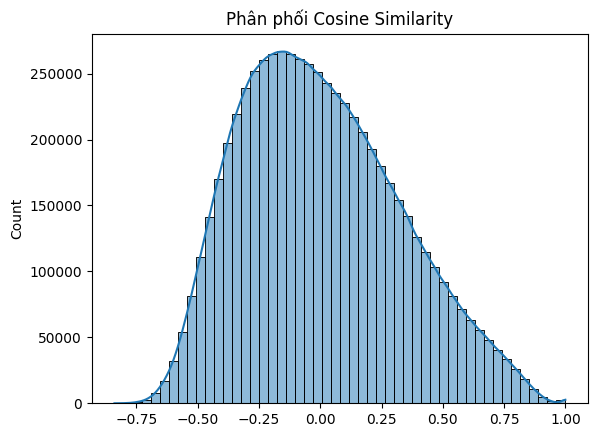

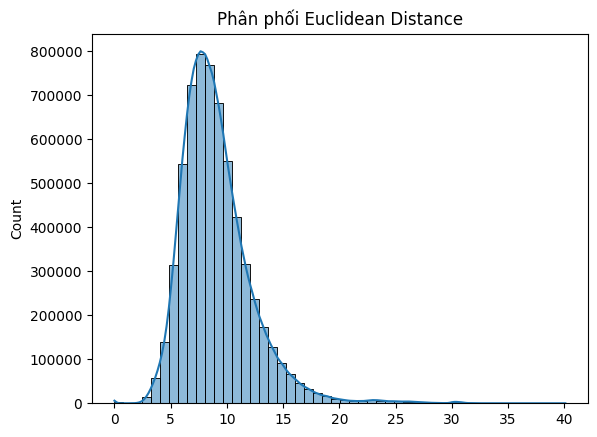

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cosine Similarity
cos_sim = cosine_similarity(X_scaled)
sns.histplot(cos_sim.flatten(), bins=50, kde=True)
plt.title("Phân phối Cosine Similarity")
plt.show()

# Euclidean Distance
from scipy.spatial.distance import pdist, squareform
euc_dist = squareform(pdist(X_scaled, metric='euclidean'))
sns.histplot(euc_dist.flatten(), bins=50, kde=True)
plt.title("Phân phối Euclidean Distance")
plt.show()

## Visualization-Based Evaluation

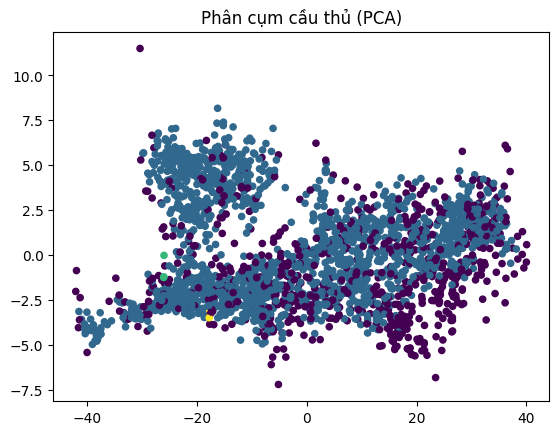

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE (2D)
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Visualization (DBSCAN labels)
plt.scatter(X_tsne[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=20)
plt.title("Phân cụm cầu thủ (PCA)")
plt.show()